# 将Gated2Depth项目分解逐步处理

### 测试  


In [6]:
#  Copyright 2018 Algolux Inc. All Rights Reserved.
#  修改自dataset_util.py
import os
import cv2
import numpy as np

crop_size = 150
# crop_size = 0


def read_gated_image(base_dir, gta_pass, img_id, data_type, num_bits=10, scale_images=False,
                     scaled_img_width=None, scaled_img_height=None,
                     normalize_images=False):
    gated_imgs = []
    normalizer = 2 ** num_bits - 1.

    for gate_id in range(3):
        gate_dir = os.path.join(base_dir, gta_pass, 'gated%d_10bit' % gate_id)
        img = cv2.imread(os.path.join(gate_dir, img_id + '.png'), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        if data_type == 'real':
            img = img[crop_size:(img.shape[0] - crop_size), crop_size:(img.shape[1] - crop_size)]
            img = img.copy()
            img[img > 2 ** 10 - 1] = normalizer
        img = np.float32(img / normalizer)
        gated_imgs.append(np.expand_dims(img, axis=2))

    img = np.concatenate(gated_imgs, axis=2)
    if normalize_images:
        mean = np.mean(img, axis=2, keepdims=True)
        std = np.std(img, axis=2, keepdims=True)
        img = (img - mean) / (std + np.finfo(float).eps)
    if scale_images:
        img = cv2.resize(img, dsize=(scaled_img_width, scaled_img_height), interpolation=cv2.INTER_AREA)
    return np.expand_dims(img, axis=0)


def read_gt_image(base_dir, gta_pass, img_id, data_type, min_distance, max_distance, scale_images=False,
                  scaled_img_width=None,
                  scaled_img_height=None, raw_values_only=False):
    if data_type == 'real':
        depth_lidar1 = np.load(os.path.join(base_dir, gta_pass, "depth_hdl64_gated_compressed", img_id + '.npz'))['arr_0']
        depth_lidar1 = depth_lidar1[crop_size: (depth_lidar1.shape[0] - crop_size),
                       crop_size: (depth_lidar1.shape[1] - crop_size)]
        if raw_values_only:
            return depth_lidar1, None

        gt_mask = (depth_lidar1 > 0.)

        depth_lidar1 = np.float32(np.clip(depth_lidar1, min_distance, max_distance) / max_distance)

        # 数组的形状将变为(1, height, width, 1)
        return np.expand_dims(np.expand_dims(depth_lidar1, axis=2), axis=0), \
               np.expand_dims(np.expand_dims(gt_mask, axis=2), axis=0) 
        # return depth_lidar1, gt_mask

    img = np.load(os.path.join(base_dir, gta_pass, 'depth_compressed', img_id + '.npz'))['arr_0']

    if raw_values_only:
        return img, None

    img = np.clip(img, min_distance, max_distance) / max_distance
    if scale_images:
        img = cv2.resize(img, dsize=(scaled_img_width, scaled_img_height), interpolation=cv2.INTER_AREA)

    return np.expand_dims(np.expand_dims(img, axis=2), axis=0), None


Text(0.5, 1.0, 'lidar')

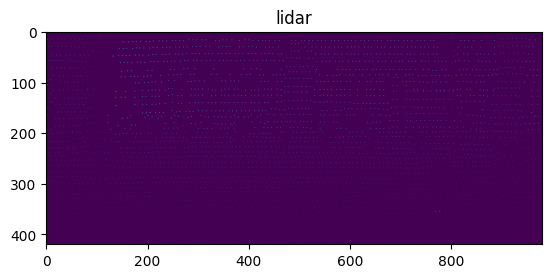

In [7]:
#测试数据读取

import matplotlib.pyplot as plt

base_dir = '../example'
gta_pass = ''
data_type = 'real'
img_id = 'example_day'
min_distance=3.
max_distance=150.

# 从数据文件中读取目标图像和激光雷达掩码
gt_patch, lidar_mask = read_gt_image(base_dir, gta_pass, img_id, data_type, min_distance, max_distance, 
                                            # raw_values_only=True
                                            )

plt.figure("lidar")
plt.imshow(gt_patch)
plt.title("lidar")




In [1]:
#测试unet
import unet
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10096)])
  except RuntimeError as e:
    print(e)
    
    
# 测试
input_img = tf.keras.Input(shape=(1280, 720, 3))
model = tf.keras.Model(inputs=input_img, outputs=unet.build_unet(input_img))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='mean_squared_error')
model.summary()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1280, 720,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 1280, 720, 3  896         ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1280, 720, 3  9248        ['conv2d[0][0]']                 
                           